In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime

In [399]:
dirs = [d for d in Path('recordings').iterdir() if d.is_dir()]

In [400]:
dirs.sort(key=lambda x: x.stem.split('-')[1:])
dirs

[PosixPath('recordings/Noodles-2025-03-06-23-24-09'),
 PosixPath('recordings/Noodles-2025-03-06-23-36-16'),
 PosixPath('recordings/Noodles-2025-03-06-23-40-54'),
 PosixPath('recordings/Noodles-2025-03-06-23-51-56'),
 PosixPath('recordings/Shak-2025-03-07-00-02-27'),
 PosixPath('recordings/Shak-2025-03-07-00-06-46'),
 PosixPath('recordings/Shak-2025-03-07-00-15-27'),
 PosixPath('recordings/Musa-2025-03-07-00-38-29'),
 PosixPath('recordings/Musa-2025-03-07-00-43-54'),
 PosixPath('recordings/musa-2025-03-07-00-47-01'),
 PosixPath('recordings/Grant-2025-03-07-00-54-57'),
 PosixPath('recordings/Grant-2025-03-07-01-01-21'),
 PosixPath('recordings/Grant-2025-03-07-01-08-21')]

(4300, 8) {'name': 'Noodles', 'age': 19, 'weight': 140, 'sex': 'm', 'start_time': 1741322454.1826212, 'notes': '', 'end_rep_markers': [7.247774124145508, 9.6057608127594, 11.973888397216797, 14.601861476898193, 16.92650032043457, 19.511471033096313, 21.732983589172363, 23.877724409103394, 26.51212430000305, 30.20060110092163]}
Total reps: 10
Rep 1/10: 7.25 s
Rep 2/10: 2.36 s
Rep 3/10: 2.37 s
Rep 4/10: 2.63 s
Rep 5/10: 2.32 s
Rep 6/10: 2.58 s
Rep 7/10: 2.22 s
Rep 8/10: 2.14 s
Rep 9/10: 2.63 s
Rep 10/10: 3.69 s


Text(0.5, 0.98, 'Noodles-2025-03-06-23-40-54')

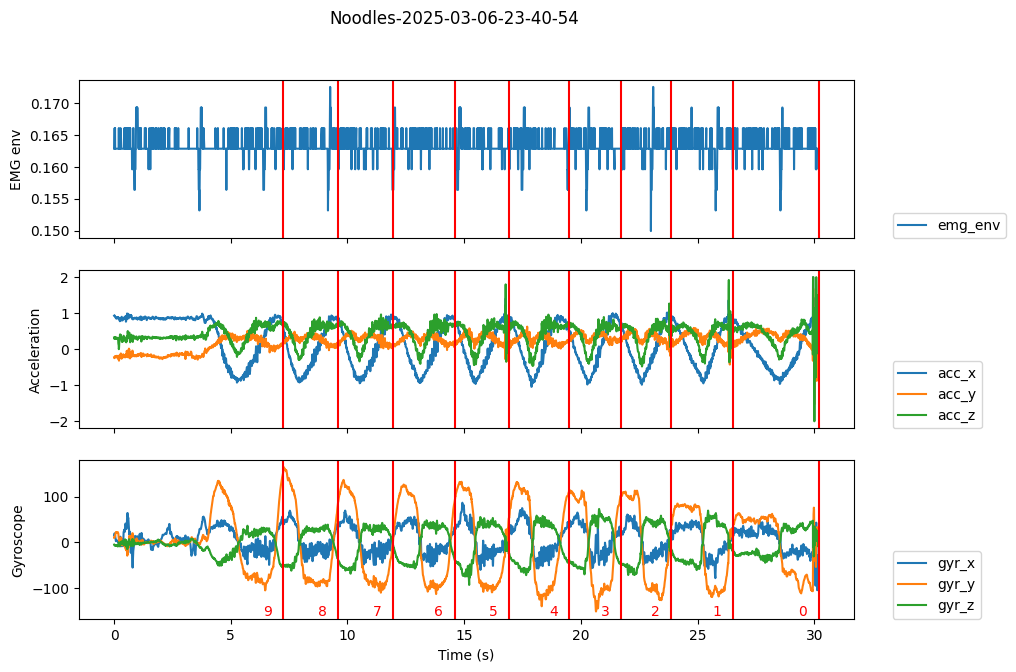

In [458]:
d = dirs[2]
df = pd.read_csv(d / 'data.csv')
df['emg_env']
info = json.load(open(d / 'info.json'))
print(df.shape, info)

total_reps = len(info['end_rep_markers'])
print('Total reps:', total_reps)
df['rir'] = -1
print(f'Rep 1/{total_reps}: {info["end_rep_markers"][0]:.2f} s')
df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
    print(f'Rep {i+2}/{total_reps}: {end-start:.2f} s')
    df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
df = df[df['rir'] != -1]

i=0
df = df.iloc[i*500:]

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(df['time'], df['emg_env'], label='emg_env')
axes[1].plot(df['time'], df[['acc_x', 'acc_y', 'acc_z']], label=['acc_x', 'acc_y', 'acc_z'])
axes[2].plot(df['time'], df[['gyr_x', 'gyr_y', 'gyr_z']], label=['gyr_x', 'gyr_y', 'gyr_z'])

axes[0].set_ylabel('EMG env')
axes[1].set_ylabel('Acceleration')
axes[2].set_ylabel('Gyroscope')
axes[2].set_xlabel('Time (s)')
[ax.legend(loc=(1.05, 0)) for ax in axes]

axes[2].set_xticks(np.arange(df['time'].iloc[0], df['time'].iloc[-1], 5))

for i,end_rep_mark in enumerate(info['end_rep_markers']):
    [ax.axvline(end_rep_mark, color='r') for ax in axes if end_rep_mark > df['time'].iloc[0]]
    axes[2].text(end_rep_mark - 0.5, 0.02, total_reps - i - 1, transform=axes[2].get_xaxis_transform(), color='r', horizontalalignment='right')

plt.suptitle(d.stem)

In [424]:
def label_rir(df, info):
    total_reps = len(info['end_rep_markers'])
    df['rir'] = -1
    df.loc[df['time'] < info['end_rep_markers'][0], 'rir'] = total_reps - 1
    for i, (start, end) in enumerate(zip(info['end_rep_markers'][:-1], info['end_rep_markers'][1:])):
        df.loc[df['time'].between(start, end), 'rir'] = total_reps - i - 2
    df = df[df['rir'] != -1]

In [427]:
not_labelled = [0, 3]
dfs =[]
for d in [dirs[i] for i in range(len(dirs)) if i not in not_labelled]:
    df = pd.read_csv(d / 'data.csv')
    info = json.load(open(d / 'info.json'))
    label_rir(df, info)
    dfs.append(df)
df = pd.concat(dfs)

In [431]:
X = df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
y = df['rir'].values

In [432]:
hz = 100
X_windowed = []
y_windowed = []
window_t = 2.5
window_size = int(hz * window_t)    # 2.5 seconds
stride_t = 0.5
stride = int(hz * stride_t)         # 0.5 seconds
for i in range(0, len(X) - window_size, stride):
    X_windowed.append(X[i:i+window_size])
    y_windowed.append(y[i:i+window_size].mean())
X_windowed = np.array(X_windowed)
y_windowed = np.array(y_windowed)
print(X_windowed.shape, y_windowed.shape)

(1326, 250, 6) (1326,)


In [443]:
len(dfs[0]) / hz

34.95

Text(0.5, 1.0, 'Rir=-0.18')

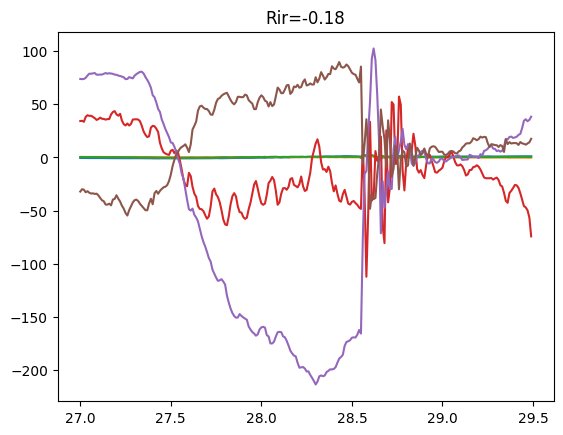

In [457]:
i = 54
plt.plot(X_windowed[i])
t = window_size / 5
tt = window_t / 5
plt.xticks(np.arange(0, window_size+1, t), np.arange(i*stride_t, i*stride_t + window_t + tt, tt));
plt.title(f'Rir={y_windowed[i]}')

In [384]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [459]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1060, 250, 6) (266, 250, 6)


In [460]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = rf.predict(X_test.reshape(X_test.shape[0], -1))
mean_squared_error(y_test, y_pred)

5.370546833106767

In [467]:
regr.rvalue**2

np.float64(0.6399987360506953)

Text(0, 0.5, 'Predicted RIR')

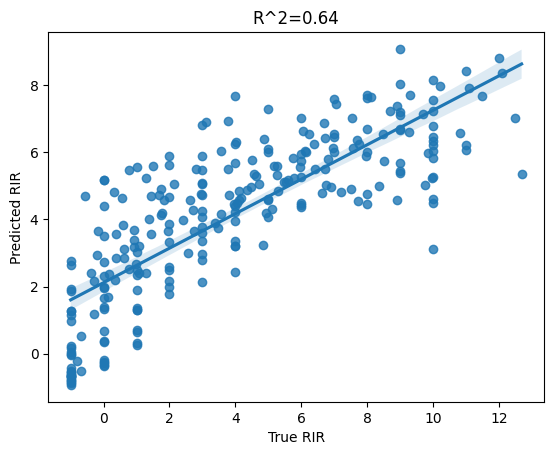

In [472]:
from scipy.stats import linregress
import seaborn as sns
regr = linregress(y_test, y_pred)
sns.regplot(x=y_test, y=y_pred)
plt.title(f'R^2={regr.rvalue**2:.2f}')
plt.xlabel('True RIR')
plt.ylabel('Predicted RIR')